In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import pathlib
from pathlib import Path
import pickle as pkl

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from models.base import LogisticRegression
from models.end2end import End2EndMLPResNet
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.gridsearch_wrapper import SkLearnGridsearchWrapper

In [2]:
class Config:
    save_dir = Path.cwd() / "results" / "ConcentricCircles"

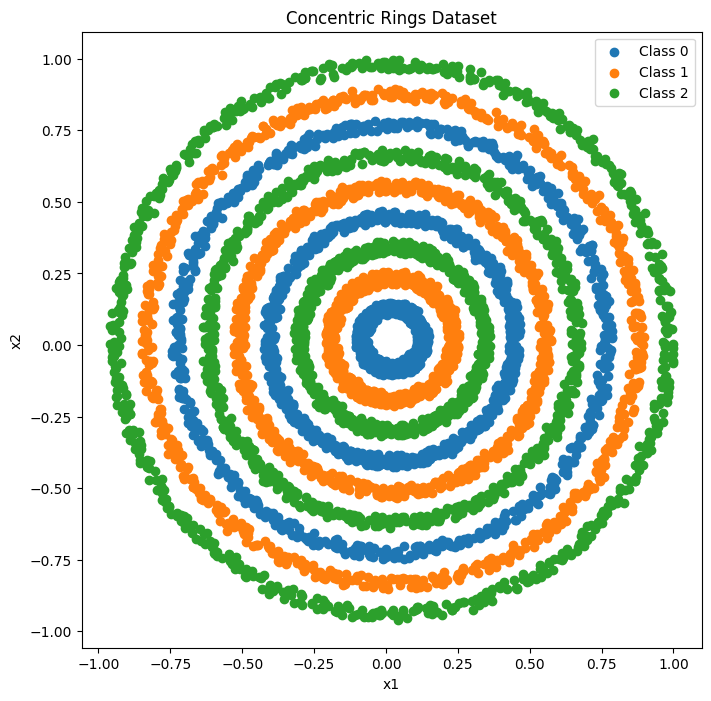

In [3]:
#######################################################
##### Create Synthetic Concentric Circles Dataset #####
#######################################################

def generate_concentric_rings(n_rings_per_class=2, n_classes=3, n_samples=2000, device="cpu", plot=False) -> Tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    n_rings = n_rings_per_class * n_classes
    samples_per_ring = n_samples // n_rings
    for i in range(n_rings):
        radius = i + 1
        theta = np.linspace(0, 2 * np.pi, samples_per_ring)
        noise_scale = 0.4
        x1 = radius * np.cos(theta) + np.random.rand(samples_per_ring) * noise_scale
        x2 = radius * np.sin(theta) + np.random.rand(samples_per_ring) * noise_scale
        X.append(np.vstack((x1, x2)).T)
        y.append(np.full(samples_per_ring, i % n_classes))
    X = np.vstack(X)
    y = np.hstack(y)
    perm = np.random.permutation(len(X))
    X = X[perm] / np.max(X)
    y = y[perm]

    #plot
    if plot:
        plt.figure(figsize=(8, 8))
        for i in range(n_classes):
            plt.scatter(X[y == i][:, 0], X[y == i][:, 1], label=f'Class {i}')
        plt.legend()
        plt.title('Concentric Rings Dataset')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

    y = torch.tensor(y).float()
    X = torch.tensor(X).float()
    if n_classes > 2:
        y = torch.nn.functional.one_hot(y.to(torch.int64), n_classes).float()
    else:
        y = y.unsqueeze(1)

    r = int(0.5 * len(X))
    X_train, y_train, X_test, y_test = X[:r], y[:r], X[r:], y[r:]
    return (X_train.to(device),
            y_train.to(device), 
            X_test.to(device), 
            y_test.to(device) )


np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
n_classes = 3
D = 2
device = "cuda"
X_train, y_train, X_test, y_test = generate_concentric_rings(
    n_rings_per_class=3, n_classes=n_classes, n_samples=6000, device=device, plot=True,
    )
if n_classes > 2:
    loss_fn = nn.functional.cross_entropy
else:
    loss_fn = nn.functional.binary_cross_entropy_with_logits

# Perform Experiments

In [4]:
import json

def save_feature_plot(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        model, 
        n_classes, 
        file_name: str,
        ):
    """
    Saves train and test features side by side for visualization at a given layer.
    
    Args:
        X_train (torch.Tensor): Features of the training set (shape: [n_samples, 2]).
        y_train (torch.Tensor): Labels of the training set (one-hot or integer-encoded).
        X_test (torch.Tensor): Features of the test set (shape: [n_samples, 2]).
        y_test (torch.Tensor): Labels of the test set (one-hot or integer-encoded).
        n_classes (int): Number of classes in the dataset.
        file_name (str): Name of the file to save the plot.
    """
    # Obtain the features at each layer
    train_features = [X_train]
    test_features = [X_test]
    if type(model) == GradientRFRBoostClassifier:
        X0_train = X_train
        X0_test = X_test
        for t, (feat_layer, ghat_layer, batchnorm) in enumerate(zip(model.random_feature_layers, 
                                                                     model.ghat_boosting_layers, 
                                                                     model.batchnorms)):
            model.train()
            features_train = feat_layer(X_train, X0_train)
            X_train = X_train + model.boost_lr * ghat_layer(features_train)
            X_train = batchnorm(X_train)
            model.eval()
            features_test = feat_layer(X_test, X0_test)
            X_test = X_test + model.boost_lr * ghat_layer(features_test)
            X_test = batchnorm(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    elif type(model) == End2EndMLPResNet:
        for resblock in model.residual_blocks:
            model.train()
            X_train = X_train + resblock(X_train)
            model.eval()
            X_test = X_test + resblock(X_test)
            train_features.append(X_train)
            test_features.append(X_test)
    else:
        raise ValueError("Model type not recognized.")
    
    # Convert labels to integers if they're one-hot encoded
    train_labels_np = y_train.argmax(dim=1).cpu().numpy() if n_classes > 2 else y_train.cpu().numpy()
    test_labels_np = y_test.argmax(dim=1).cpu().numpy() if n_classes > 1 else y_test.cpu().numpy()

    # Plot the features
    fontsize=30
    name = "E2E MLP ResNet" if type(model) == End2EndMLPResNet else "RFRBoost"
    custom_cmap = ListedColormap(['#ff7f0e', '#2ca02c', '#1f77b4'])  # Orange, Green, Blue
    T = len(train_features)
    for name_train_or_test, features, labels in [("train", train_features, train_labels_np), 
                                                 ("test", test_features, test_labels_np)]:
        fig, axes = plt.subplots(1, T, figsize=(T * 4, 4), dpi=100)
        for t in range(T):
            ax = axes[t]
            feat = features[t].detach().cpu().numpy()

            ax.scatter(feat[:, 0], feat[:, 1], c=labels, cmap=custom_cmap, s=40, alpha=0.5, edgecolors='none')

            # Remove titles and adjust axis
            ax.axis('equal')
            ax.axis('off')

            # Add black border as a rectangle
            rect = patches.Rectangle(
                (0, 0), 1, 1, transform=ax.transAxes,  # Set size relative to axes
                linewidth=2, edgecolor='black', facecolor='none', zorder=10
            )
            ax.add_patch(rect)

        # Add vertical label for the model name
        fig.text(0.015, 0.5, name, fontsize=fontsize, rotation='vertical', va='center', ha='center')

        plt.tight_layout()
        plt.subplots_adjust(left=0.03)  # Add space for the model name
        Config.save_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(Config.save_dir / f"{file_name}_{name_train_or_test}.png", bbox_inches='tight', dpi=300)
        plt.close(fig)



def run_concentric_rings_experiment(
        num_experiments: int = 10,
        n_classes=3,
        n_rings_per_class=3,
        n_samples=10000,
        device="cpu",
        validation_strategy: Literal["holdout", "kfold"] = "kfold",
        kfolds: int = 5,
        holdout_percentage: float = 0.2,
        seed: Optional[int] = 0,
        ):
    """Runs the concentric circle experiments and saves the plots and results."""
    # Define models and their hyperparameter grids
    n_layers = 3
    bottleneck_dim = 512
    model_specs = {
        "RFRBoost SWIM": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'l2_ghat': [1e-4],
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [2],
            'n_layers': [n_layers],
            'randfeat_xt_dim': [bottleneck_dim],
            'randfeat_x0_dim': [bottleneck_dim],
            'upscale_type': ["identity"],
            'feature_type': ["SWIM"],
            'SWIM_scale': [1.0],
            'activation': ["tanh"],
            "use_batchnorm": [True],
            "boost_lr": [1.0],
        },
        "RFNN": {
            'modelClass': [GradientRFRBoostClassifier],
            'l2_cls': np.logspace(-4, 0, 5),
            'in_dim': [2],
            'n_classes': [n_classes],
            'hidden_dim': [bottleneck_dim],
            'n_layers': [0],
            'upscale_type': ["SWIM"],
            'SWIM_scale': [1.0],
            'activation': ["tanh"],
        },
        "Logistic Regression": {
            'modelClass': [LogisticRegression],
            'l2_lambda': np.logspace(-4, 0, 5),
            'n_classes': [n_classes],
        },
        "End2EndMLP": {
            'modelClass': [End2EndMLPResNet],
            'lr': np.logspace(-5, -1, 5),
            'in_dim': [2],
            'hidden_dim': [2],
            'bottleneck_dim': [bottleneck_dim],
            'out_dim': [n_classes if n_classes > 2 else 1],
            'n_blocks': [n_layers],
            'loss': ["cce" if n_classes > 2 else "bce"],
            'n_epochs': [30],
            'end_lr_factor': [0.01],
            'weight_decay': [0.00001],
            'batch_size': [128],
            'upsample': [False],
            'activation': [nn.Tanh()],
        },
    }

    # Run experiments
    results = {}
    results_params = {}
    for model_name, param_grid in model_specs.items():
        accuracies = []
        best_params = []
        modelClass = param_grid.pop("modelClass")[0]
        for i in range(num_experiments):
            # Create dataset
            X_train, y_train, X_test, y_test = generate_concentric_rings(
                n_rings_per_class, n_classes, n_samples, device
            )

            # Perform grid search
            gs_model = SkLearnGridsearchWrapper(
                modelClass=modelClass,
                param_grid={**param_grid},
                reg_or_cls="classification",
                validation_strategy=validation_strategy,
                kfolds=kfolds,
                holdout_percentage=holdout_percentage,
                seed=seed+i,
                verbose=3,
            )
            gs_model.fit(X_train, y_train)
            accuracy = gs_model.score(X_test, y_test)
            accuracies.append(accuracy)
            best_params.append(gs_model.best_params_)
            print(i, model_name, "test acc", accuracy, "params", gs_model.best_params_)

            if i==num_experiments-1 and ("RFRBoost" in model_name or "MLP" in model_name): #could do 
                print("plotting and saving feature evolution point cloud")
                save_feature_plot(X_train, y_train, X_test, y_test, gs_model.best_model.model, n_classes, model_name)
        results[model_name] = accuracies
        results_params[model_name] = best_params

    # Save results to a file
    with open(Config.save_dir / f"combined_results.pkl", "wb") as f:
        pkl.dump(results, f)

    return results, results_params

In [ ]:
results, results_params = run_concentric_rings_experiment(
    num_experiments=10,
    device="cuda",
    validation_strategy="kfold",
    kfolds=5,
    # validation_strategy="holdout",
    # holdout_percentage=0.3,
)

for model_name, accs in results.items():
    print(model_name, "acc", np.mean(accs), "std", np.std(accs))
    print(accs)
    print()
for model_name, best_params in results_params.items():
    print(model_name, "best params", best_params)
    print()



In [10]:
with open(Config.save_dir / "combined_results.pkl", "rb") as f:
    results = pkl.load(f)
results

{'RFRBoost SWIM': [0.9989999532699585,
  0.9959999918937683,
  0.9979999661445618,
  0.9917999505996704,
  0.996999979019165,
  0.998199999332428,
  0.9977999925613403,
  0.9983999729156494,
  0.9989999532699585,
  0.993399977684021],
 'RFNN': [0.8611999750137329,
  0.8553999662399292,
  0.9145999550819397,
  0.8497999906539917,
  0.8795999884605408,
  0.8569999933242798,
  0.9413999915122986,
  0.8799999952316284,
  0.9601999521255493,
  0.8709999918937683],
 'Logistic Regression': [0.30699998140335083,
  0.38359999656677246,
  0.3278000056743622,
  0.33219999074935913,
  0.2978000044822693,
  0.334199994802475,
  0.3247999846935272,
  0.337799996137619,
  0.362199991941452,
  0.3287999927997589],
 'End2EndMLP': [0.7773999571800232,
  0.9031999707221985,
  0.613599956035614,
  0.8327999711036682,
  0.9508000016212463,
  0.6021999716758728,
  0.6685999631881714,
  0.8601999878883362,
  0.5112000107765198,
  0.5992000102996826]}

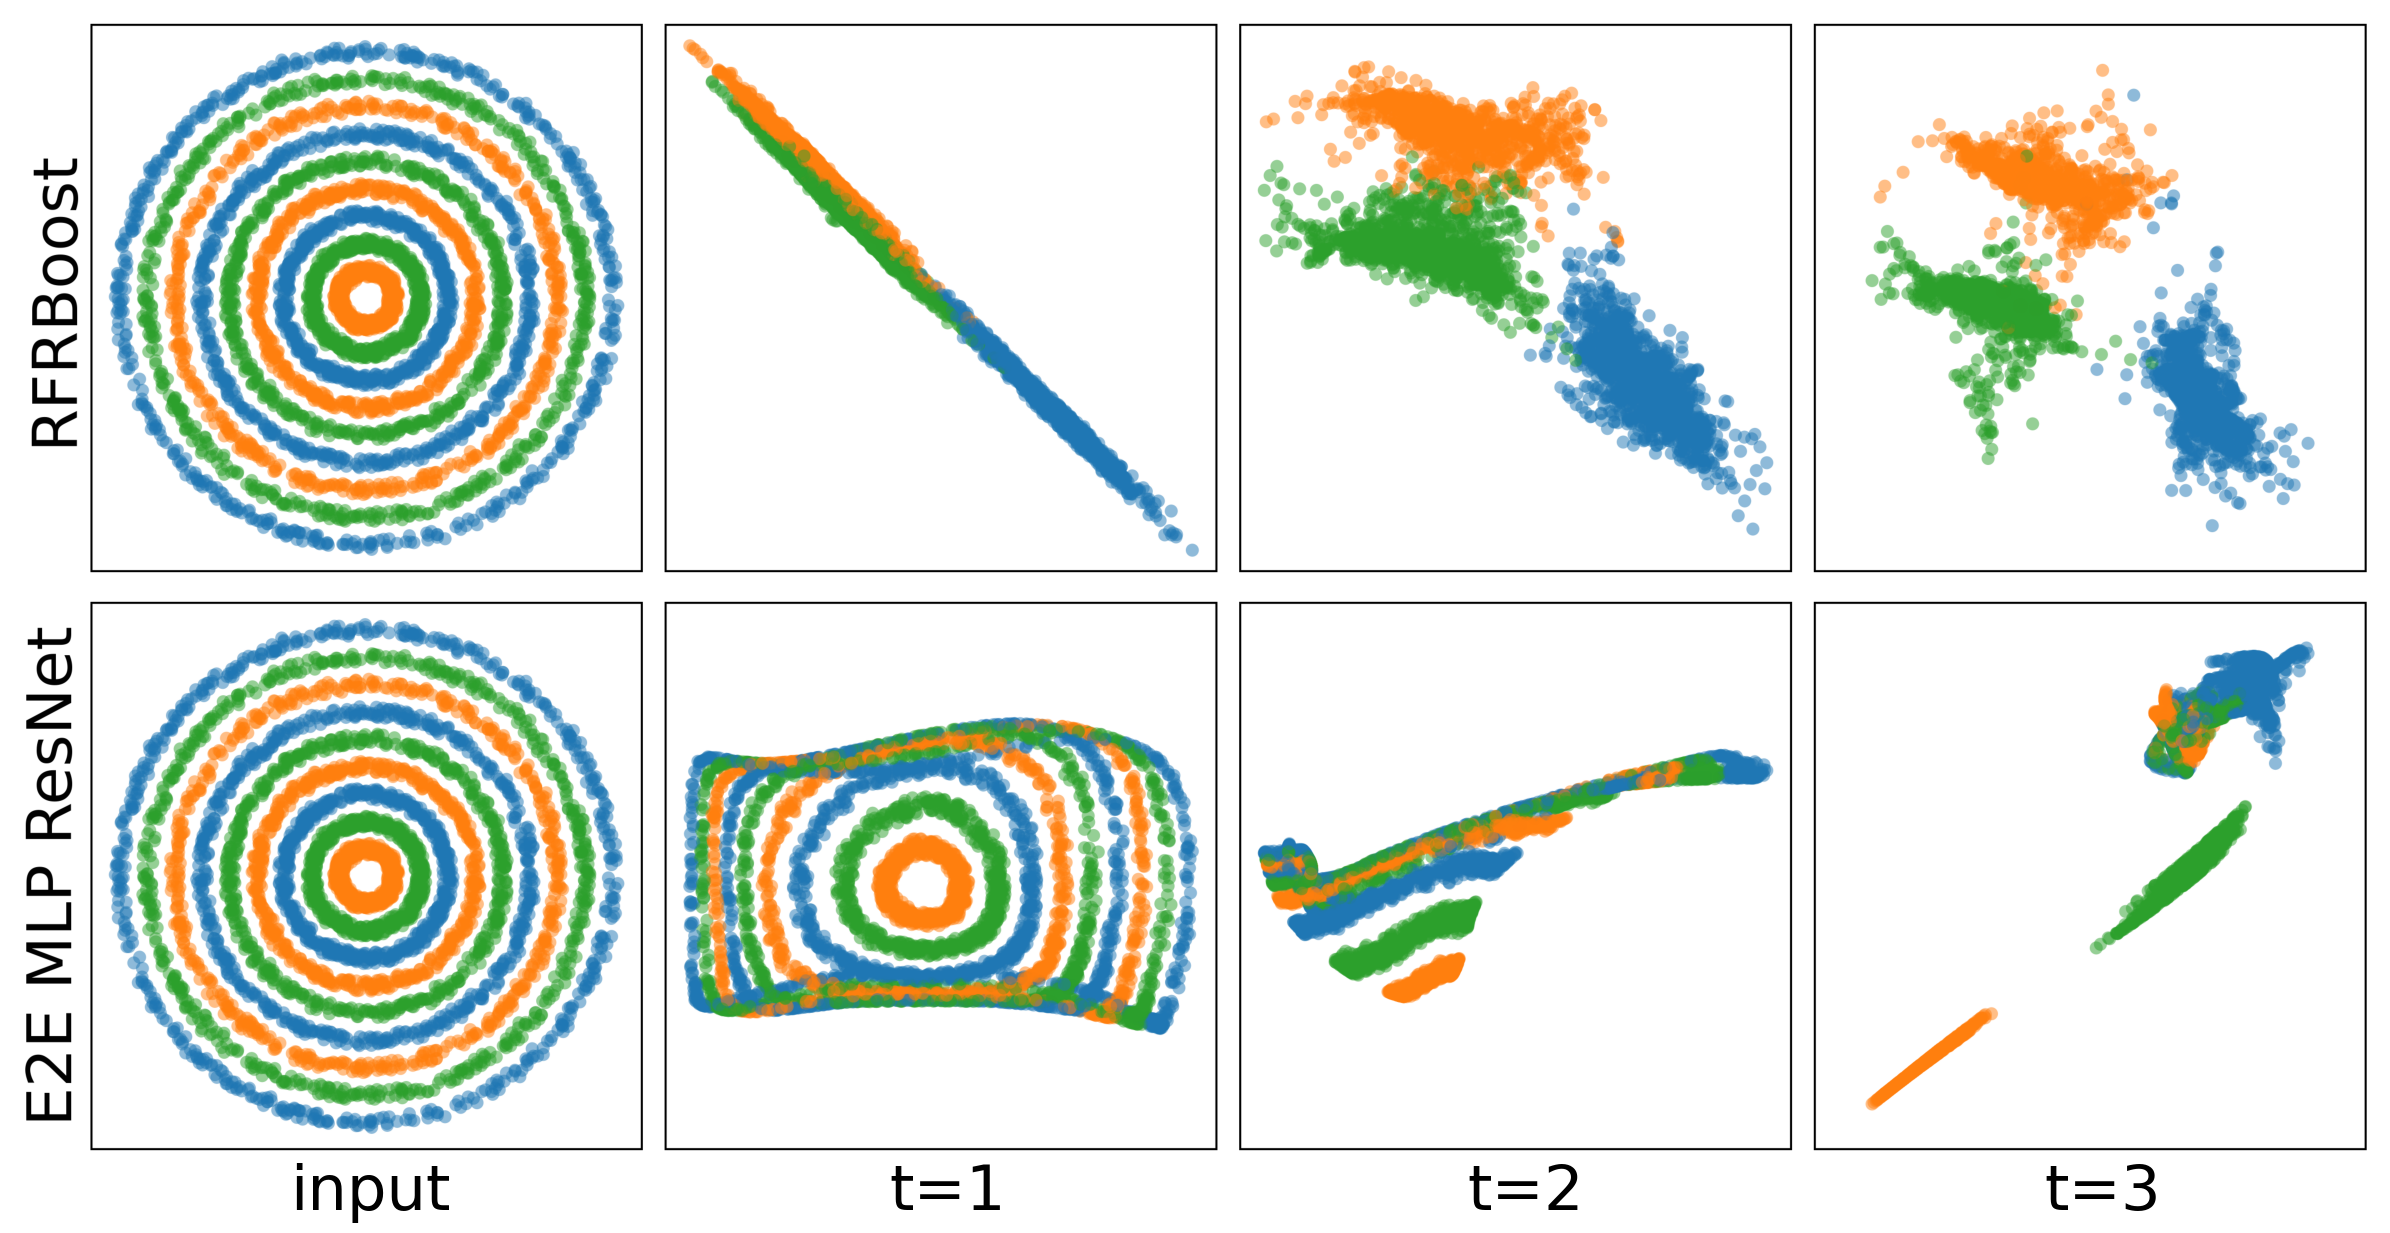

In [8]:
def make_combined_plot():
    # List of image paths
    plots = [
        "results/ConcentricCircles/RFRBoost SWIM_test.png",
        "results/ConcentricCircles/End2EndMLP_test.png"
    ]

    # Create a figure to hold the subplots
    fig, axes = plt.subplots(len(plots), 1, figsize=(30, 15))

    # Loop through the images and add them to the subplots
    for ax, plot in zip(axes, plots):
        img = mpimg.imread(plot)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes

    # Add text below the subplots
    left_indent = 0.225
    height = 0.08
    fig.text(left_indent, height, 'input', ha='center', fontsize=45)
    for t in range(1, 3+1):
        fig.text(left_indent + t/4*0.77, height, f't={t}', ha='center', fontsize=45)
    # Adjust layout to avoid overlap and reduce vertical space
    plt.subplots_adjust(left=0.01, right=0.99, hspace=0.0001)
    plt.savefig("results/ConcentricCircles/ConcentricEvolution.png", bbox_inches='tight')
    plt.show()
    plt.close()

make_combined_plot()

In [11]:
def create_latex_table(results):
    table = """
\\begin{table}[t]
\\caption{Average test accuracies on the concentric circles point cloud separation task, averaged across 10 runs.}
\\label{tab:concentric-circles}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Mean Acc & Std Dev \\\\
\\midrule
"""
    for model_name, accs in results.items():
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        table += f"{model_name} & {mean_acc:.3f} & {std_acc:.3f} \\\\\n"
    
    table += """
\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table

# Example usage
latex_table = create_latex_table(results)
print(latex_table)


\begin{table}[t]
\caption{Average test accuracies on the concentric circles point cloud separation task, averaged across 10 runs.}
\label{tab:concentric-circles}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & Mean Acc & Std Dev \\
\midrule
RFRBoost SWIM & 0.997 & 0.002 \\
RFNN & 0.887 & 0.037 \\
Logistic Regression & 0.334 & 0.023 \\
End2EndMLP & 0.732 & 0.144 \\

\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}

